# Sentinel 3

In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
from io import StringIO
from functools import partial
import numpy as np

# from WaterClass2.fitting import *

import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

# from nbdev.showdoc import *
# from WaterClass2.Radiometry import *

# from WaterClass2.core import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
s3bands = [400, 412.5, 442, 490, 510, 560, 620, 665, 674, 681, 709, 754, 779, 865, 885, 1020]


def open_radiometry(path):
    old_names = [f'Oa{str(i).zfill(2)}_reflectance:float' for i in range(1, 22)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(13,16)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(19,21)]
    df = pd.read_csv(path).rename(columns={old_names[i]: s3bands[i] for i in range(16)})    
    return df


def normalize(df, bands, norm_band):
    df = df.copy()
    df[bands] = df[bands].to_numpy() - df[norm_band].to_numpy()[..., None]
    return df


def clip_negatives(df, bands, threshold=-0.1):
    return df.loc[~((df[bands] < -0.1).any(axis=1))]


def clean_radiometry(df, min_threshold=-0.1, norm_band=1020):

    if norm_band is not None:
        df = normalize(df, s3bands, 1020)

    df = clip_negatives(df, s3bands, -0.1)

    return df


def load_radiometries(path):

    csvs = [f for f in path.iterdir()]

    radiometries = {}
    min_pixels = 10

    for i, csv in enumerate(csvs):
        df = open_radiometry(csvs[i])
        if len(df) > 10:
            radiometries[csv.stem[16:24]] = df
            
    return radiometries

In [5]:
# file = Path(r'C:\Users\Mauricio Cordeiro\Downloads\14100000_manacapuru\S3A_OL_2_WFR____20161123T134634_20161123T134834_20171105T005133_0119_011_181______MR1_R_NT_002.csv')
# df = open_radiometry(file)
# plot_reflectances2(df, s3bands, color='T865:float', hover_vars=[], log_color=False)

## Load DataFrames in memory

In [6]:
base_path = Path(r'D:\S3\stations\14100000_manacapuru')

csvs = [f for f in base_path.iterdir()]

radiometries = {}
min_pixels = 10

for i, csv in enumerate(csvs):
    df = open_radiometry(csvs[i])
    if len(df) > 10:
        radiometries[csv.stem[16:24]]= df

## Calculate the mean using RAW data

In [7]:
df = pd.DataFrame()

for radiometry in radiometries:
    df = df.append(radiometries[radiometry].mean().rename(radiometry))

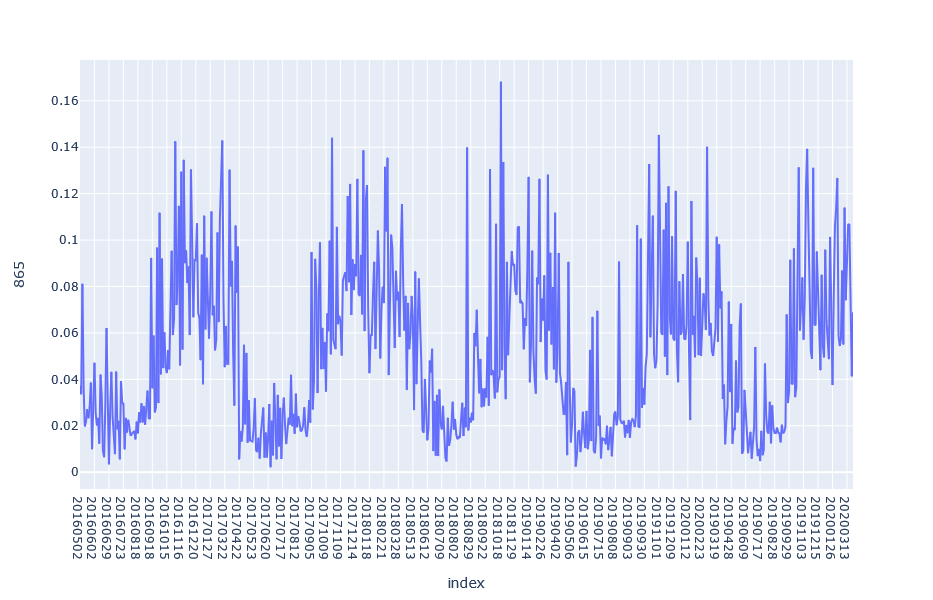

In [10]:
px.line(df, y=865, height=600, )

In [11]:
df[865].mean(),df[865].std()

(0.051597804402232106, 0.03439599452796976)

## Calc mean radiometry (getting 10% of pixels with abs(SWIR) closest to Zero)

In [12]:
df = pd.DataFrame()

for date, radiometry in radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=None) 
    radiometry['abs_1020'] = radiometry[1020].abs()
    radiometry = radiometry[radiometry['abs_1020']<radiometry['abs_1020'].quantile(q=0.20)]
    
    df = df.append(radiometry.mean().rename(date))

C:\Users\david\.conda\envs\git-prj\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



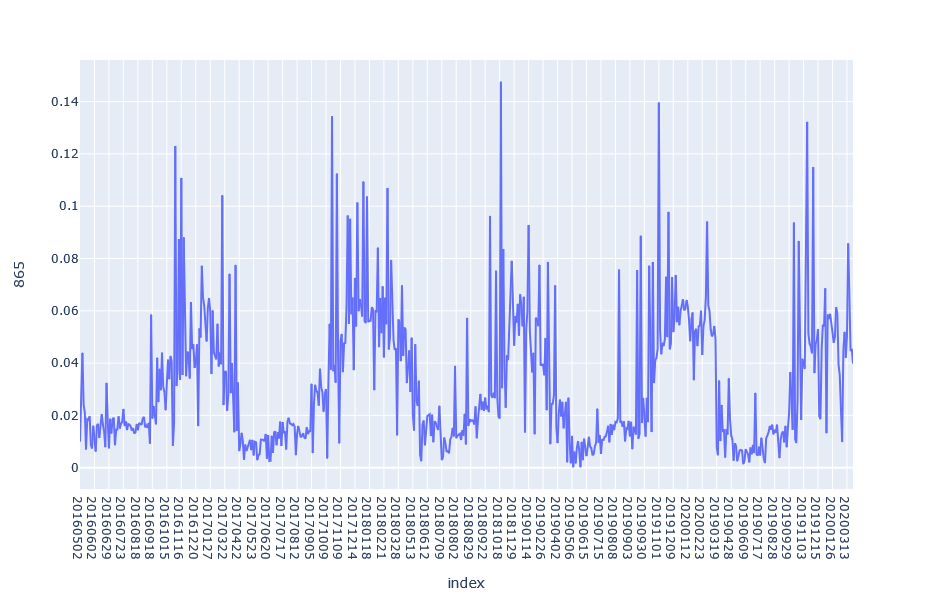

In [13]:
px.line(df, y=865, height=600,)

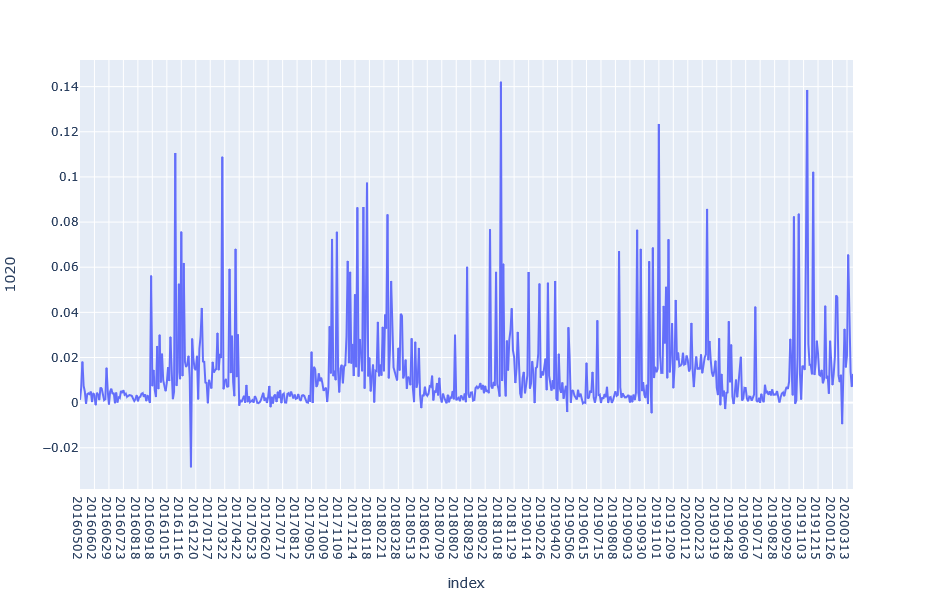

In [14]:
px.line(df, y=1020, height=600,)

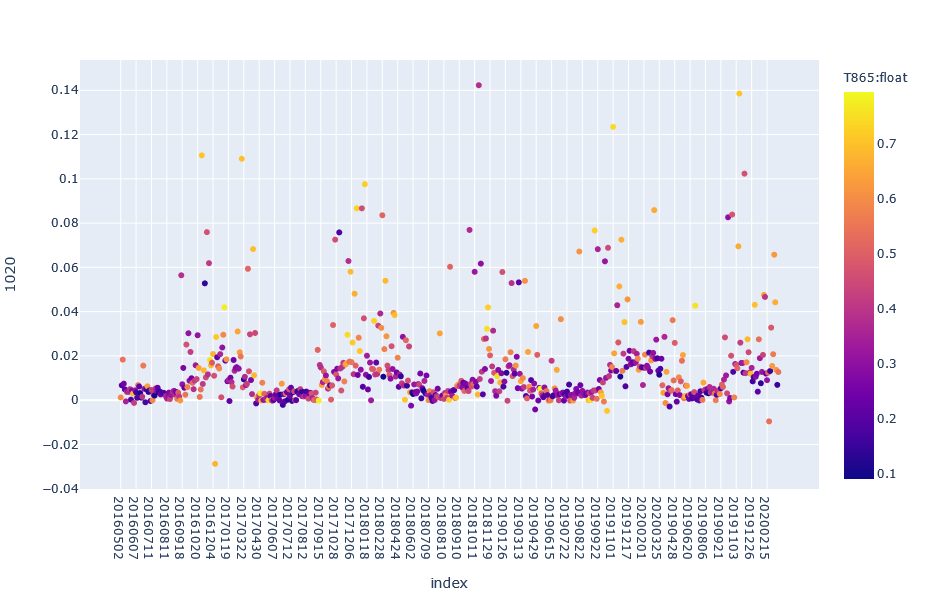

In [16]:
px.scatter(df, y=1020, height=600, color='T865:float')

In [17]:
df[865].mean(),df[865].std()

(0.03202786513515965, 0.025189817207206044)

## Calc mean radiometry (Normalized in 1020)

In [18]:
df = pd.DataFrame()

for date, radiometry in radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=1020) 
    df = df.append(radiometry.mean().rename(date))

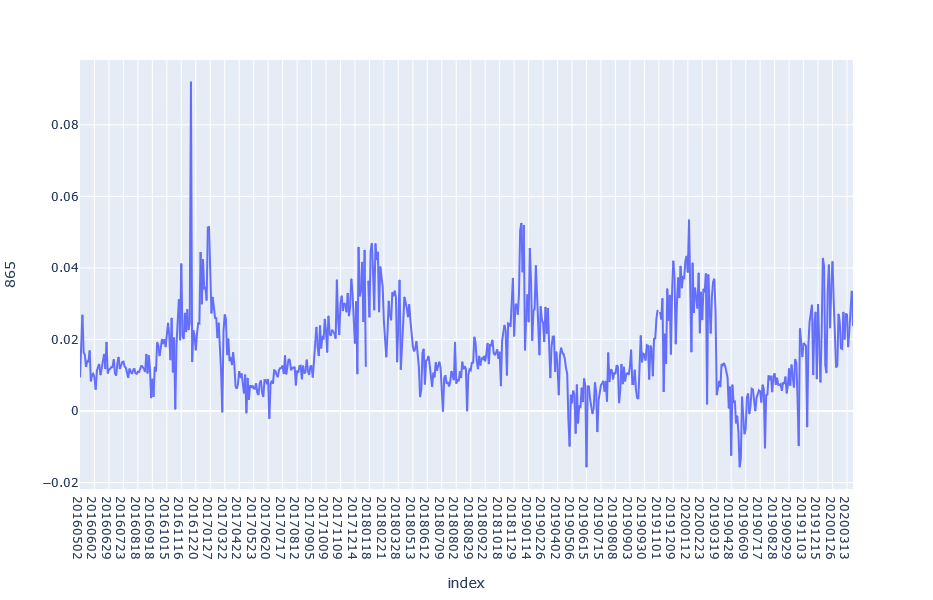

In [19]:
px.line(df, y=865, height=600,)

In [20]:
def calc_nd_index(df, band1, band2, column_name='nd_index'):
    idx = (df[band1]-df[band2])/(df[band1]+df[band2])
    df[column_name] = idx
    
def db_scan(df, bands, column_name='cluster', eps=0.1, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df[bands])
    df[column_name] = clustering.labels_
    

## Calc Clusters

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [22]:
radiometries = load_radiometries(Path(r'D:\processing\linux\14100000_manacapuru_v15'))

In [ ]:
df = pd.DataFrame()

for date, radiometry in radiometries.items():
    
    # clean some outliars  using the indices
    calc_nd_index(radiometry, 560, 1020, column_name='mndwi')
    calc_nd_index(radiometry, 560, 865, column_name='ndwi')
    
    valid_mndwi = (radiometry['mndwi'] > -0.95) & (radiometry['mndwi'] < 0.95)
    valid_ndwi = (radiometry['ndwi'] > -0.95) & (radiometry['ndwi'] < 0.95)
    
    radiometry = radiometry[valid_mndwi & valid_ndwi]
    
    if len(radiometry) < 5:
        continue 
    db_scan(radiometry, [865, 1020], eps=0.01)
    clusters = radiometry.groupby(by='cluster').mean()
    
    # drop the noise
    clusters.drop(-1, inplace=True, errors='ignore')
    
    # if there is at least 1 valid cluster
    if len(clusters) > 0:
        df = df.append(clusters[clusters[1020] == clusters[1020].min()].iloc[0].rename(date))

In [26]:
df.columns

Index([               400,              412.5,                442,
                      490,                510,                560,
                      620,                665,                674,
                      681,                709,                754,
                      779,                865,                885,
                     1020,       'A865:float',         'ABSVLDPX',
                  'GLINT',        'OAA:float',        'OZA:float',
                'QUALITY',        'SAA:float',        'SZA:float',
             'T865:float',       'Unnamed: 0',  'WQSF_lsb:double',
        'latitude:double', 'longitude:double',            'mndwi',
                   'ndwi',                'x',                'y'],
      dtype='object')

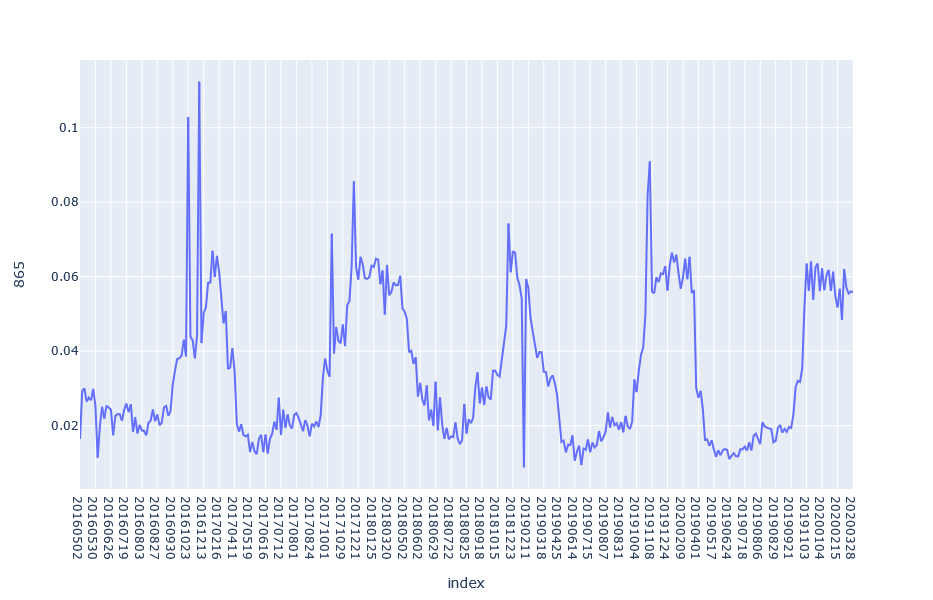

In [27]:
px.line(df, y=865, height=600,)

In [418]:
df = list(radiometries.values())[6]
df = radiometries['20160704']
# clean some outliars  using the indices
calc_nd_index(df, 560, 1020, column_name='mndwi')
calc_nd_index(df, 560, 865, column_name='ndwi')

valid_mndwi = (df['mndwi'] > -0.95) & (df['mndwi'] < 0.95)
valid_ndwi = (df['ndwi'] > -0.95) & (df['ndwi'] < 0.95)

df = df[valid_mndwi | valid_ndwi]


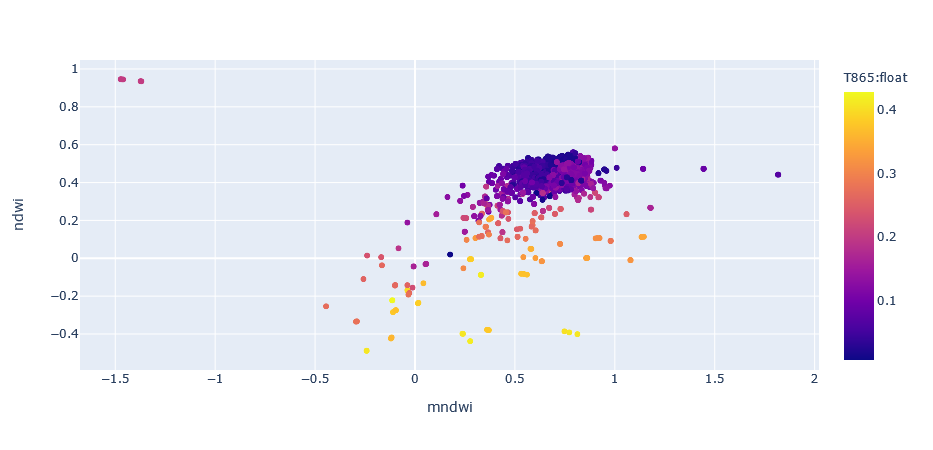

In [419]:
px.scatter(df, x='mndwi', y='ndwi', color='T865:float')

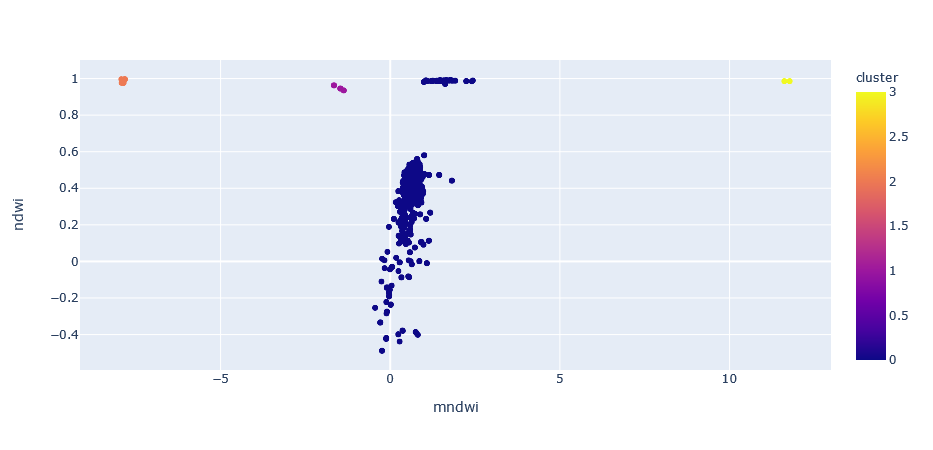

In [409]:
db_scan(df, ['mndwi', 'ndwi'], eps=0.5)
px.scatter(df, x='mndwi', y='ndwi', color='cluster')

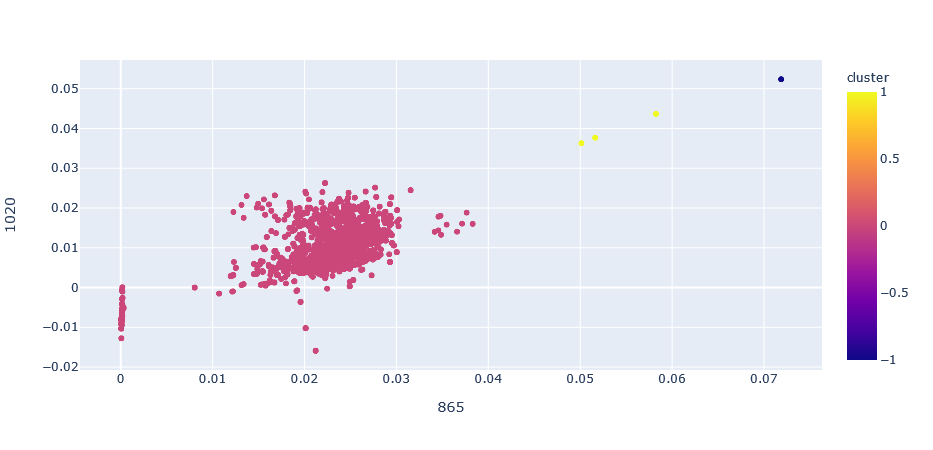

In [410]:
db_scan(df, [865, 1020], eps=0.01)
px.scatter(df, x=865, y=1020, color='cluster')

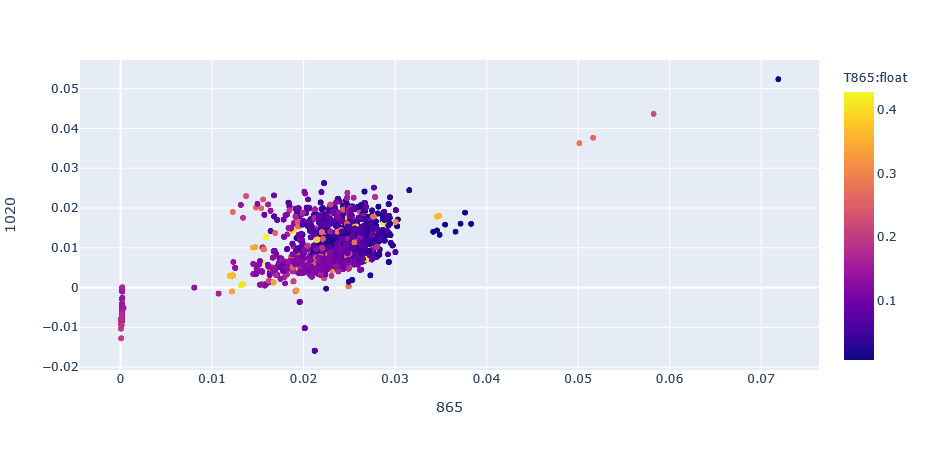

In [411]:
px.scatter(df, x=865, y=1020, color='T865:float')

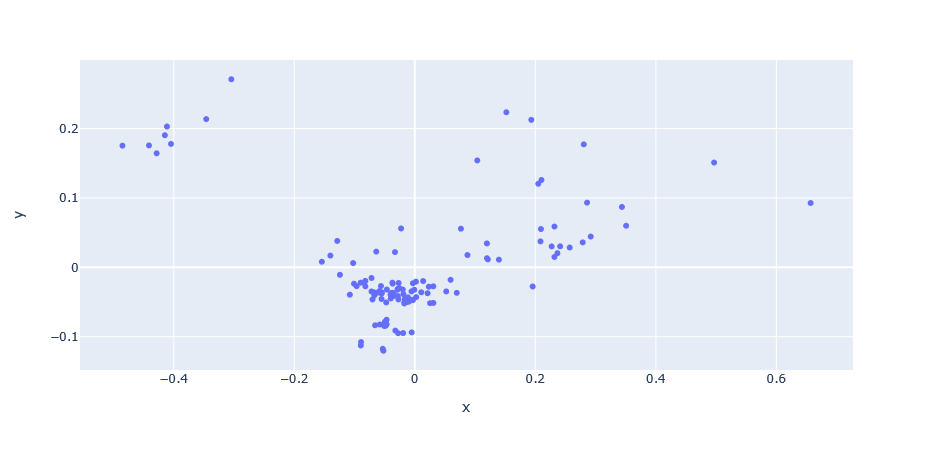

In [284]:
components = pca.fit_transform(df[s3bands].to_numpy())
px.scatter(x=components[:, 0], y=components[:, 1])

In [279]:
pca.components_.shape

(2, 16)

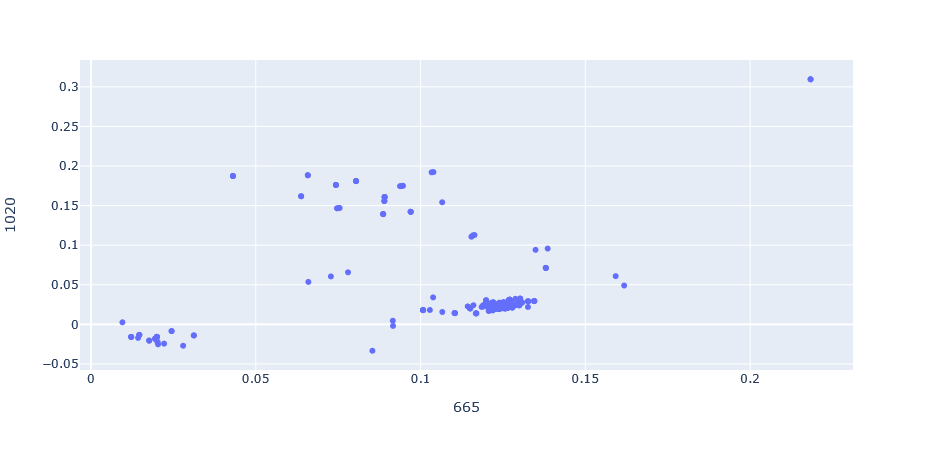

In [263]:
px.scatter(df, 665, 1020)

In [248]:
df = pd.DataFrame()

for date, radiometry in radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=1020) 
    df = df.append(radiometry.mean().rename(date))

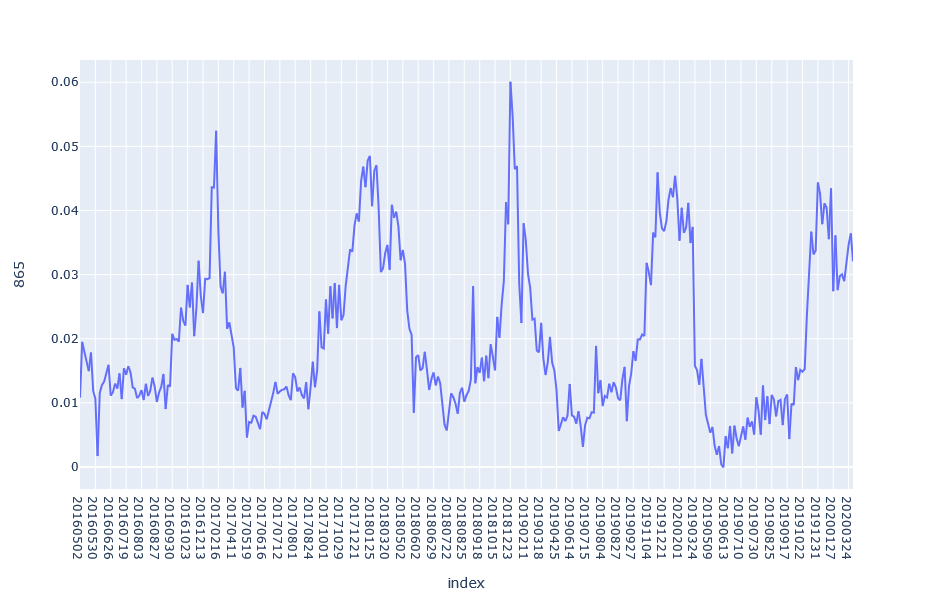

In [249]:
px.line(df, y=865, height=600,)

## Calc mean radiometry (getting 10% of pixels with abs(SWIR) closest to Zero)

In [256]:
df = pd.DataFrame()

for date, radiometry in radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=None) 
    radiometry['abs_1020'] = radiometry[1020].abs()

    radiometry = radiometry[radiometry['abs_1020']<radiometry['abs_1020'].quantile(q=0.05)]
    
    df = df.append(radiometry.mean().rename(date))

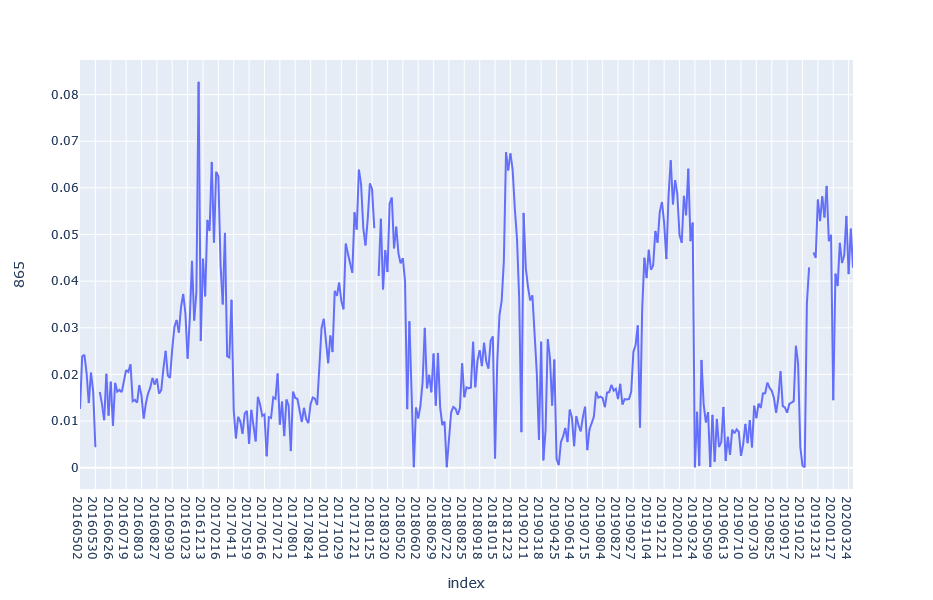

In [257]:
px.line(df, y=865, height=600,)

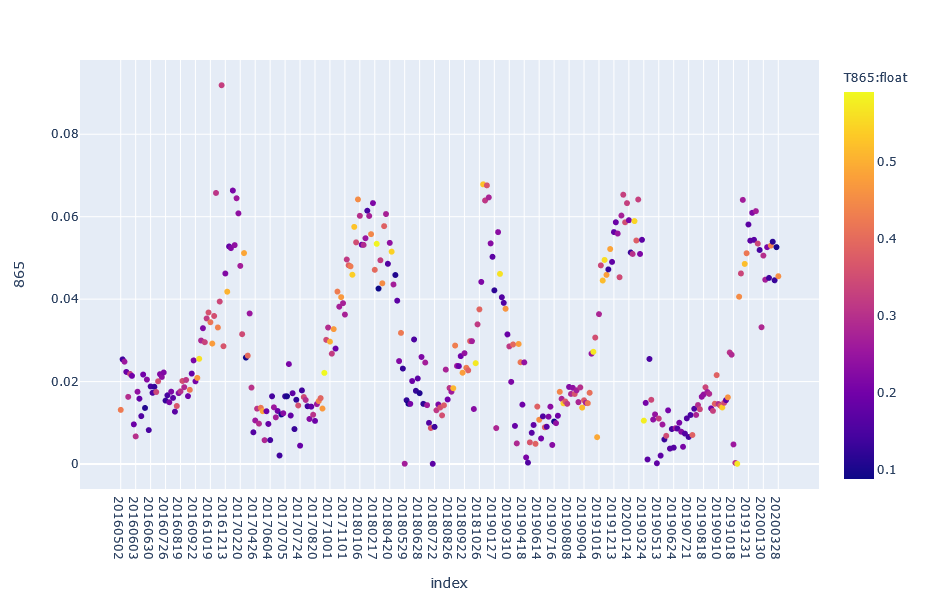

In [255]:
px.scatter(df, y=865, height=600, color='T865:float')